In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# isFraudifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
df.isnull().sum().max()

0

In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]), ' of the dataset')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Frauds 8213  of the dataset


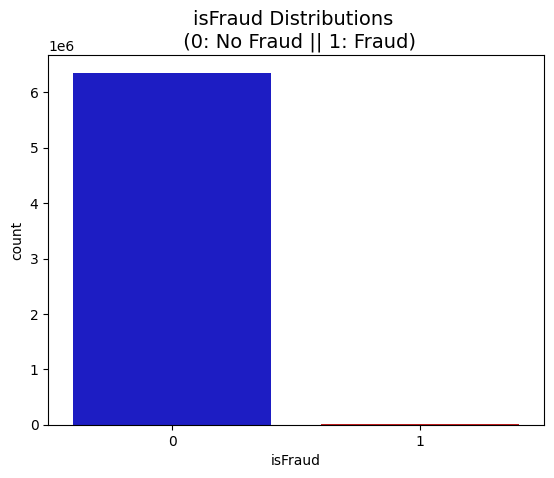

In [6]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x ='isFraud', data=df, palette=colors)
plt.title('isFraud Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Label encoding
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
df['nameOrig_encoded'] = le.fit_transform(df['nameOrig'])
df['nameDest_encoded'] = le.fit_transform(df['nameDest'])


# Display the transformed DataFrame
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   type_encoded  nameOrig_encoded  nameDest_encoded  
0             3            757869           

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,3,757869,1662094
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,3,2188998,1733924
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,4,1002156,439685
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,5828262,391696
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,3,3445981,828919


In [9]:
df = df.drop(['type', 'nameOrig', 'nameDest'], axis=1)

In [10]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,3,757869,1662094
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,3,2188998,1733924
2,1,181.00,181.0,0.00,0.0,0.0,1,0,4,1002156,439685
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,5828262,391696
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,3,3445981,828919


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('isFraud', axis=1)
y = df['isFraud']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

In [24]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# amount of fraud classes 8213 rows.
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:8213]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,nameOrig_encoded,nameDest_encoded
3757533,279,151050.57,203266.00,354316.57,0.00,0.00,0,0,0,3954082,304274
6162024,550,217434.23,56838.22,274272.45,2043626.88,1826192.64,0,0,0,652539,349901
3741797,279,601222.02,601222.02,0.00,0.00,0.00,1,0,4,2301322,99091
5179871,359,7428844.46,7428844.46,0.00,0.00,0.00,1,0,4,2644920,527610
6278025,641,2938833.22,2938833.22,0.00,0.00,2938833.22,1,0,1,5766926,257753


Distribution of the Classes in the subsample dataset
isFraud
0    0.5
1    0.5
Name: count, dtype: float64


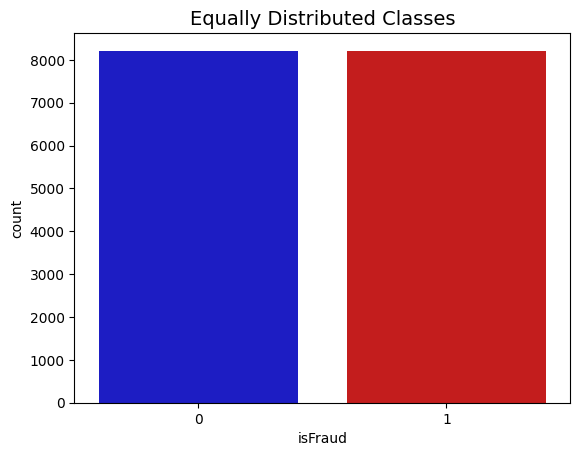

In [25]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['isFraud'].value_counts()/len(new_df))



sns.countplot(x='isFraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

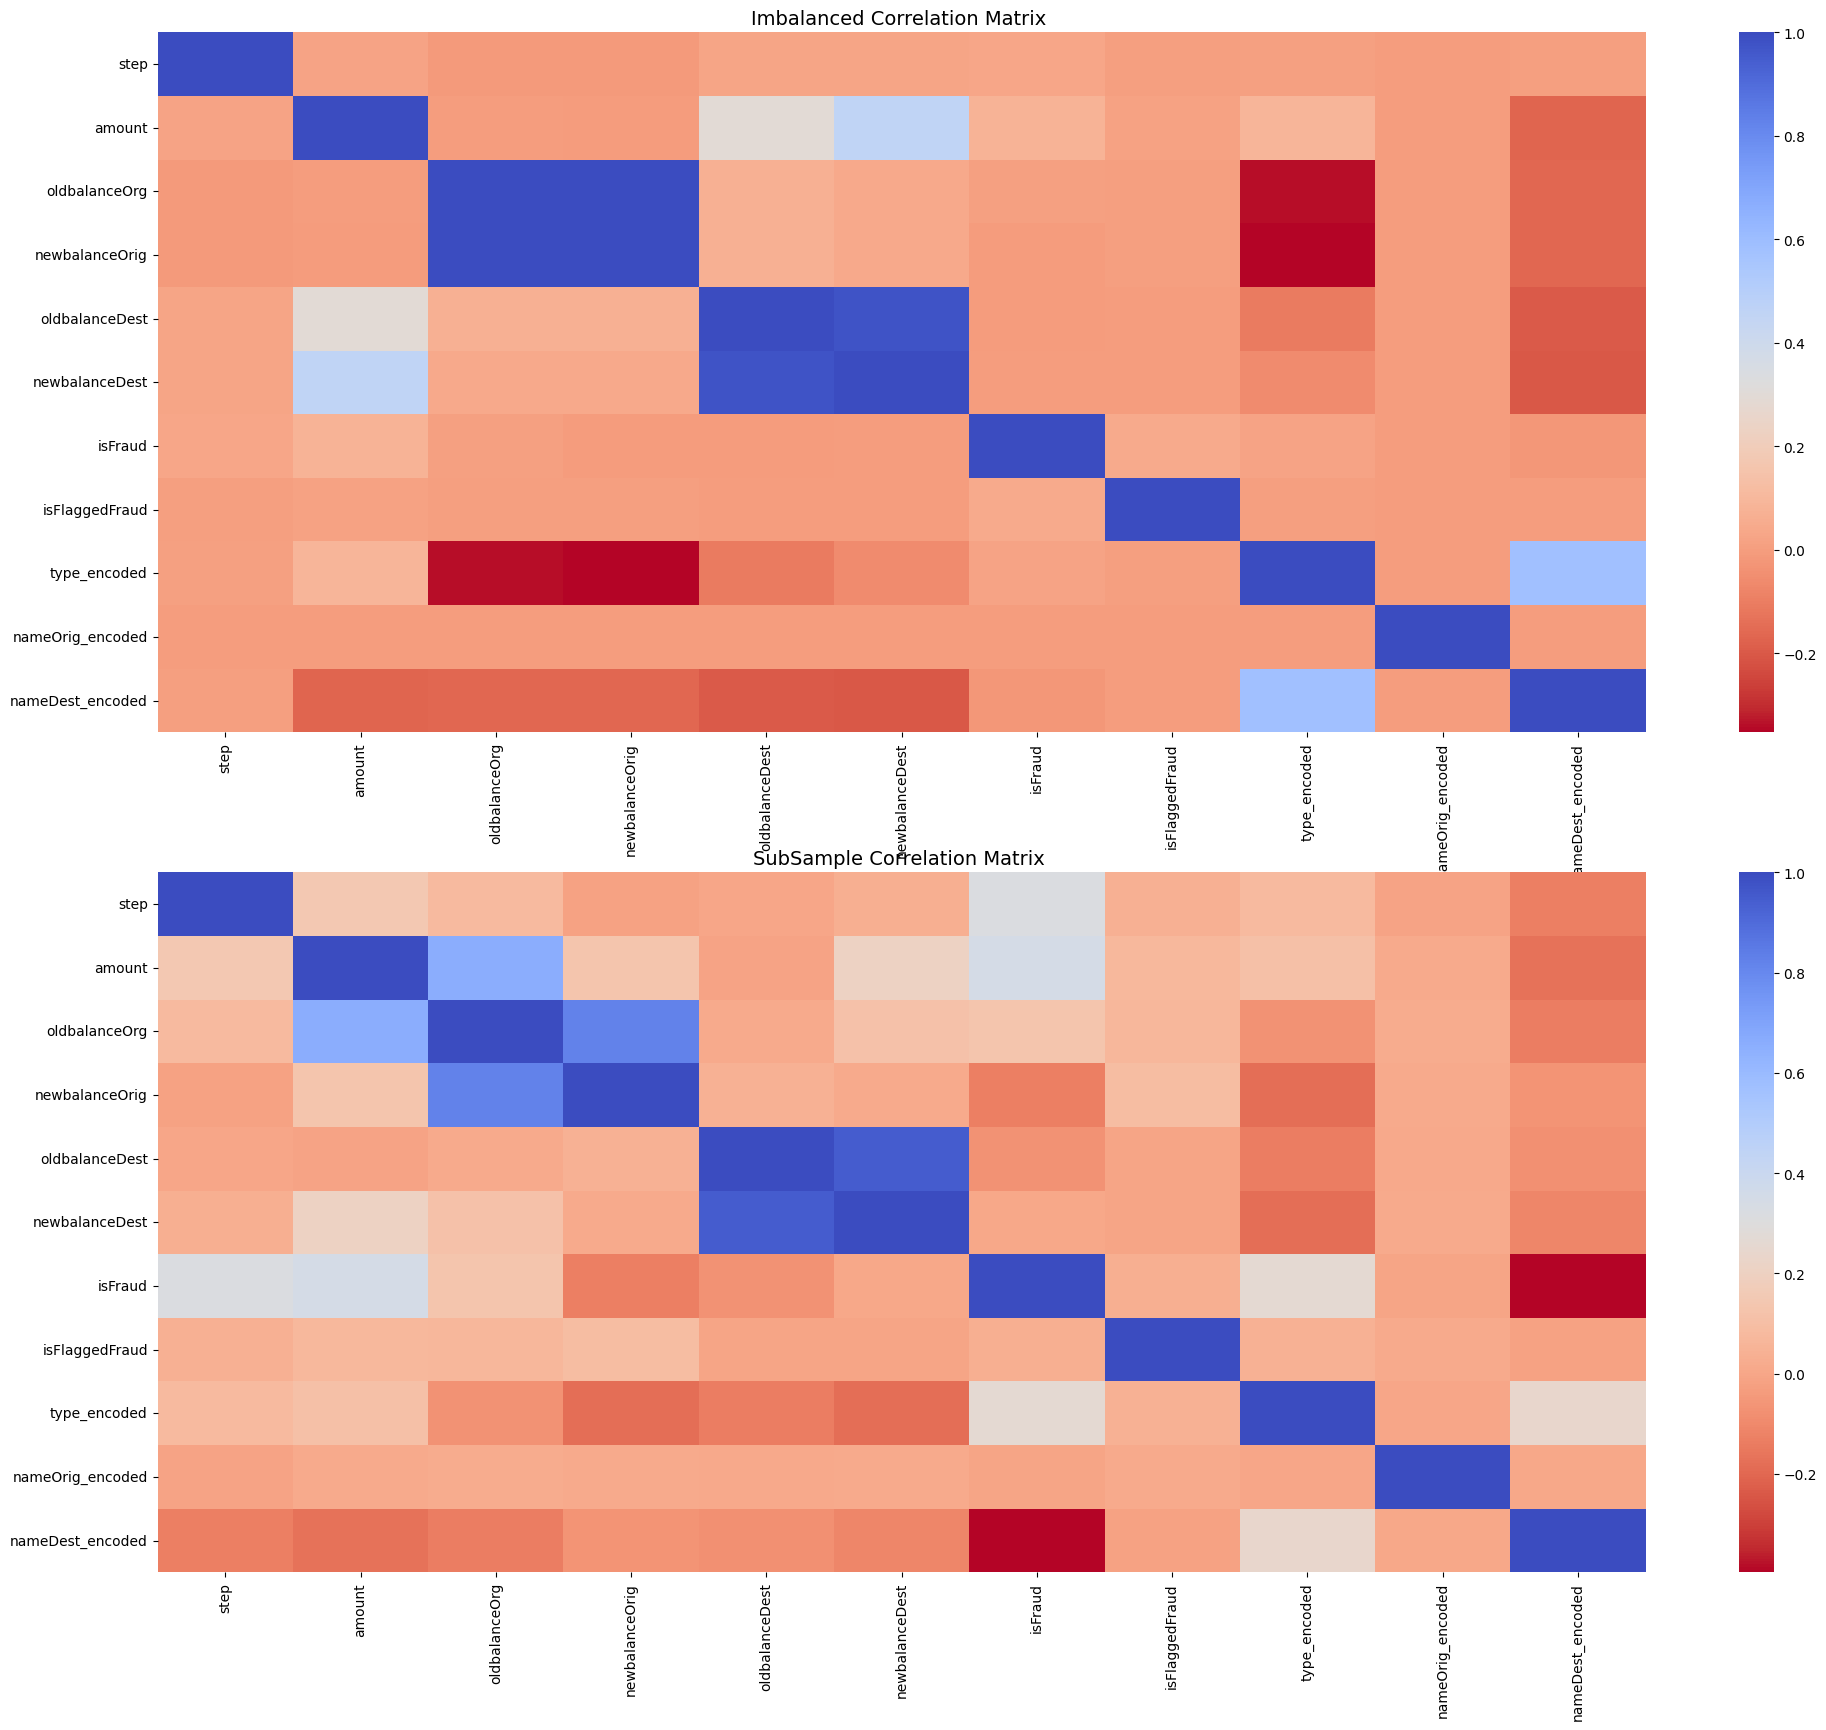

In [26]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix ", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix ', fontsize=14)
plt.show()

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

data = new_df
data.dropna(axis=0, subset=['isFraud'], inplace=True)
y = data.isFraud
X = data.drop(['isFraud'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [60]:
test_y

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [34]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assume 'X' is your feature matrix and 'y' is your target variable (e.g., fraud detection labels)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate XGBRegressor with some custom parameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # This is for regression tasks; use 'binary:logistic' for classification
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Fit the model on the training data
xgb_reg.fit(train_X, train_y)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
# make predictions
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 0.0205354124486649


In [40]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

IndexError: index 4 is out of bounds for axis 0 with size 4

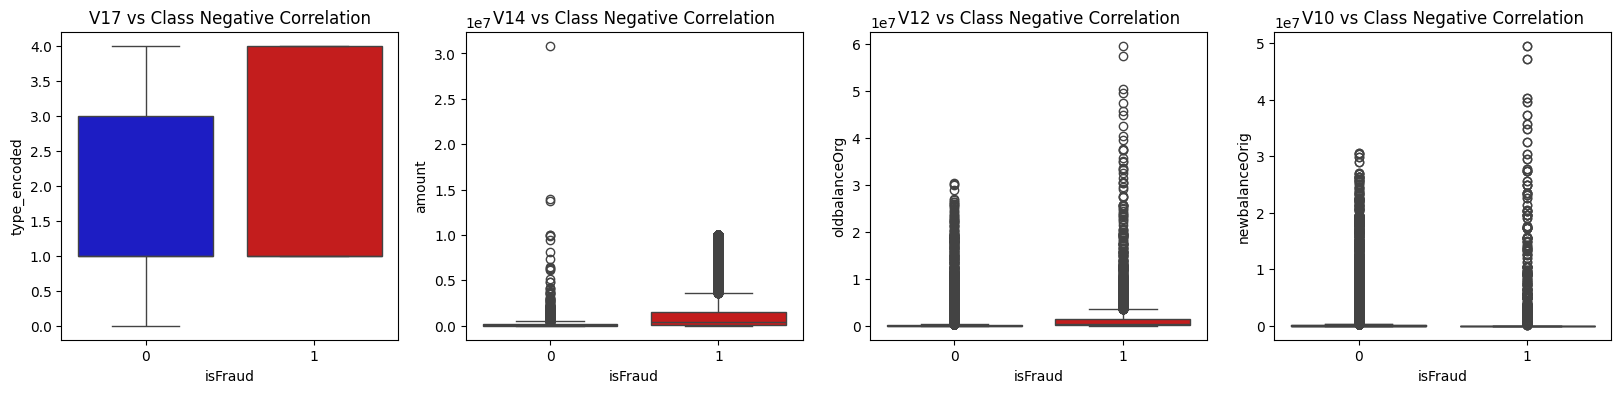

In [20]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="isFraud", y="type_encoded", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="isFraud", y="amount", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="isFraud", y="oldbalanceOrg", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="isFraud", y="newbalanceOrig", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="isFraud", y="newbalanceOrig", data=new_df, palette=colors, ax=axes[3])
axes[4].set_title('V10 vs Class Negative Correlation')

plt.show()

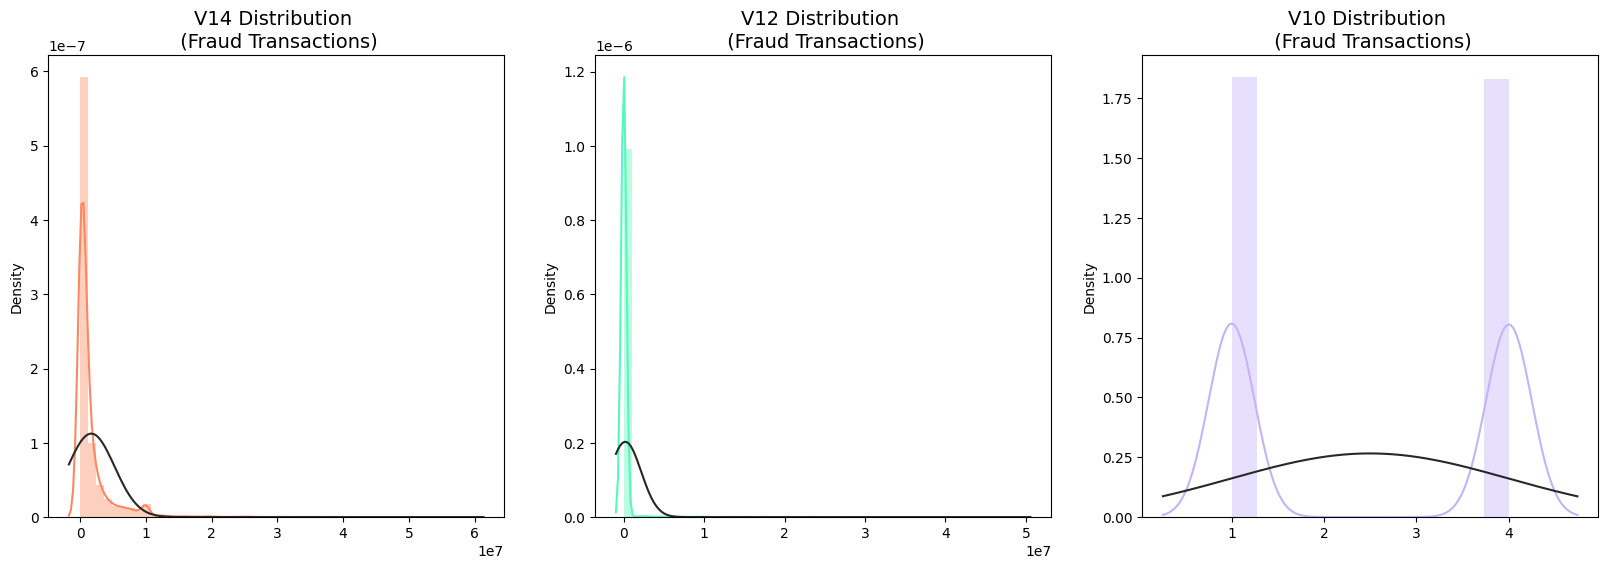

In [22]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['oldbalanceOrg'].loc[new_df['isFraud'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['newbalanceOrig'].loc[new_df['isFraud'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['type_encoded'].loc[new_df['isFraud'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [26]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(original_Xtrain, original_ytrain, verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 2.8 MB/s eta 0:00:45
    --------------------------------------- 1.6/124.9 MB 3.0 MB/s eta 0:00:42
    --------------------------------------- 2.4/124.9 MB 3.2 MB/s eta 0:00:39
   - -------------------------------------- 3.4/124.9 MB 3.5 MB/s eta 0:00:35
   - -------------------------------------- 4.7/124.9 MB 4.0 MB/s eta 0:00:30
   - -------------------------------------- 6.0/124.9 MB 4.4 MB/s eta 0:00:27
   -- ------------------------------------- 7.6/124.9 MB 4.9 MB/s eta 0:00:24
   --- ------------------------------------ 9.4/124.9 MB 5.3 MB/s eta 0:00:22
   --- ------------------------------------ 11.5/124.9 MB 5.8 MB/s eta 0:00:20
   ---- ----------------------------------- 14.4/124.9 MB 6.5 MB/s eta 0:00:17
   ----- ---------------------------------- 17.3/124.9 MB 7.2 MB/s eta 0:00:

In [15]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install sklearn.preprocessing

Note: you may need to restart the kernel to use updated packages.


In [43]:
from xgboost import XGBClassifier
RANDOM_STATE = 42
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(train_X,train_y, eval_set = [(test_X,test_y)], early_stopping_rounds = 50)
# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. The parameter 
# early_stopping_rounds is the number of iterations that it will wait to check if the cost function decreased or not.
# If not, it will stop and get the iteration that returned the lowest metric on the eval set.

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define RANDOM_STATE for reproducibility
RANDOM_STATE = 42

# Define the XGBClassifier model
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1, random_state=RANDOM_STATE)

# Fit the model with early stopping
xgb_model.fit(
    train_X, train_y, 
    eval_set=[(test_X, test_y)], 
   # eval_metric="logloss",  # Choose the evaluation metric
    #early_stopping_rounds=50,  # Early stopping rounds
    verbose=True  # Show progress
)

[0]	validation_0-logloss:0.60680
[1]	validation_0-logloss:0.53348
[2]	validation_0-logloss:0.47222
[3]	validation_0-logloss:0.41957
[4]	validation_0-logloss:0.37466
[5]	validation_0-logloss:0.33597
[6]	validation_0-logloss:0.30217
[7]	validation_0-logloss:0.27281
[8]	validation_0-logloss:0.24666
[9]	validation_0-logloss:0.22320
[10]	validation_0-logloss:0.20258
[11]	validation_0-logloss:0.18472
[12]	validation_0-logloss:0.16884
[13]	validation_0-logloss:0.15482
[14]	validation_0-logloss:0.14233
[15]	validation_0-logloss:0.13086
[16]	validation_0-logloss:0.12047
[17]	validation_0-logloss:0.11132
[18]	validation_0-logloss:0.10300
[19]	validation_0-logloss:0.09554
[20]	validation_0-logloss:0.08887
[21]	validation_0-logloss:0.08300
[22]	validation_0-logloss:0.07747
[23]	validation_0-logloss:0.07287
[24]	validation_0-logloss:0.06869
[25]	validation_0-logloss:0.06450
[26]	validation_0-logloss:0.06059
[27]	validation_0-logloss:0.05719
[28]	validation_0-logloss:0.05410
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
xgb_model.best_iteration

AttributeError: `best_iteration` is only defined when early stopping is used.

In [49]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9981
Metrics test:
	Accuracy score: 0.9985


In [53]:
y_pred = xgb_model.predict(X_test)

In [61]:
y_pred

array([0, 1, 0, ..., 0, 1, 1])

In [56]:
precision = precision_score(test_y, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [4107, 3286]

In [62]:
print(f'Length of test_y: {len(test_y)}')
print(f'Length of y_pred: {len(y_pred)}')

Length of test_y: 4107
Length of y_pred: 3286
